#**Retail Sales Analysis with Python and SQL - Using a real-world dataset**

**Project Goal:** Help an online retailer understand its past performance: top-selling products, revenue trends, and customer activity.


I will use Python to clean the data, perform EDA, RFM analysis, Basket Analysis with FP-Growth, then create a database and use SQL to query it.

##Python

###Data Cleaning

>Load and preview the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sqlite3
from mlxtend.frequent_patterns import association_rules, fpgrowth
import warnings
import io, requests

warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
url= "https://raw.githubusercontent.com/gerakisg/UK_Online_Retail_Transactions/main/data/Online%20Retail.xlsx"

try:
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    original_df = pd.read_excel(io.BytesIO(r.content))
except Exception as e:
    raise FileNotFoundError(
        f"Failed to download from GitHub URL.\nOriginal error: {e}"
    )

In [3]:
df = original_df

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


--------------------------------------------------------------------------------

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

**Description:** Product (item) name. Nominal.

**Quantity:** The quantities of each product (item) per transaction. Numeric.

**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.

**UnitPrice:** Unit price. Numeric, Product price per unit in sterling (British pounds).

**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

**Country:** Country name. Nominal, the name of the country where each customer resides.

--------------------------------------------------------------------------------

In [4]:
print("Original Shape:", df.shape)

Original Shape: (541909, 8)


Our dataset has a total of 541909 rows (records) and 8 columns (features).

Let's delete duplicate records if they exist.

In [5]:
df = df.drop_duplicates()

In [6]:
print("New Shape:", df.shape)

New Shape: (536641, 8)


Rows decreased so duplicate records existed and were removed.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    536641 non-null  object        
 1   StockCode    536641 non-null  object        
 2   Description  535187 non-null  object        
 3   Quantity     536641 non-null  int64         
 4   InvoiceDate  536641 non-null  datetime64[ns]
 5   UnitPrice    536641 non-null  float64       
 6   CustomerID   401604 non-null  float64       
 7   Country      536641 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.8+ MB


We can observe that some columns are of dtype "object". These are categorical or text fields.

The columns of Dtype "int64" or "float64" are numerical columns with integer or decimal values, respectively.

The "InvoiceDate" column is of Dtype "datetime64[ns]", a timestamp value.

Importantly, we can see that the features "Description" and "CustomerID" have null values.

Let's add a boolean column for cancelled transactions for better readability.

In [8]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [9]:
df = df.copy(deep=False)
df['IsCancelled'] = df['InvoiceNo'].astype(str).str.startswith('C')

In [10]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,False
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,False
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,False
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,False


In [11]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,536641.000000,536641,536641.000000,401604.000000
mean,9.620029,2011-07-04 08:57:06.087421952,4.632656,15281.160818
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 10:52:00,1.250000,13939.000000
50%,3.000000,2011-07-19 14:04:00,2.080000,15145.000000
75%,10.000000,2011-10-18 17:05:00,4.130000,16784.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,219.130156,NaN,97.233118,1714.006089


Some baseline statistics for our features such as minimum and maximum values, mean and IQR.

Some important observations are that 75% of Quantity values are lower than equal to 10, but the maximum is 80995.

The maximum UnitPrice value is 38970 but 75% of the values are below 5.

These outliers should be inspected in order to figure out if they are errors or valid records.

We also observe that 'Quantity' and 'UnitPrice' include negative values.

UnitPrice negative values do not hold any logical meaning and thus can be misleading and should be removed. Zero values can be attributed to promotions, bundles etc. and thus hold some logical value and could be part of an analysis.

Quantity negative values can be connected to cancelled transactions but that needs to be investigated. Zero values do not hold any logical meaning and thus are probably misleading and should be removed.

Inspect records with UnitPrice < 0.

In [12]:
df[(df['UnitPrice'] < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,False
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,False


These two records are not related to any sale and should be deleted.

We notice that the StockCode is different than the standard. We should check if more of these exist and what they are related to.

In [13]:
df = df[(df['UnitPrice'] >= 0)]

In [14]:
invalid_unitprice = df[(df['UnitPrice'] == 0)].copy()
invalid_unitprice['DescriptionFilled'] = invalid_unitprice['Description'].fillna('UNKNOWN')
invalid_unitprice = invalid_unitprice.groupby(['DescriptionFilled']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
invalid_unitprice.head(10)

,DescriptionFilled,Count
239,UNKNOWN,1454
270,check,159
5,?,47
280,damages,45
278,damaged,43
296,found,25
337,sold as set on dotcom,20
260,adjustment,16
93,Damaged,14
112,FRENCH BLUE METAL DOOR SIGN 1,9


Inspect records with Quantity == 0

In [15]:
df[(df['Quantity'] == 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled


Remove them

In [16]:
df = df[(df['Quantity'] != 0)]

In [17]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135035
Country,0
IsCancelled,0


Here we can see exactly how many null values exist in each column.

Null Descriptions are not a problem for any particular analysis.

Null CustomerIDs are only a problem for customer-specific analysis but we can exclude them later instead of deleting them.

Lets investigate StockCodes that are not in the intended format.

In [18]:
df[~df['StockCode'].astype(str).str.match(r'^\d')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,False
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,True
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,False
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,False
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911.0,EIRE,False
...,...,...,...,...,...,...,...,...,...
541540,581498,DOT,DOTCOM POSTAGE,1,2011-12-09 10:26:00,1714.17,NaN,United Kingdom,False
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,True
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.00,12662.0,Germany,False
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.00,12526.0,Germany,False


Let's get the most common Description for each of those StockCodes and sort by frequency.

In [19]:
# Filter for StockCodes that do NOT start with a digit
invalid_stockcodes = df[~df['StockCode'].astype(str).str.match(r'^\d')]

# Treat null descriptions explicitly as a label (e.g., 'UNKNOWN') for grouping
invalid_stockcodes = invalid_stockcodes.copy()
invalid_stockcodes['DescriptionFilled'] = invalid_stockcodes['Description'].fillna('UNKNOWN')

# Group by StockCode and Descriptions, count pair occurrences
grouped = invalid_stockcodes.groupby(['StockCode', 'DescriptionFilled']).size().reset_index(name='Count')

# For each StockCode, get the most common Description
most_common_desc = grouped.sort_values(['StockCode', 'Count'], ascending=[True, False]) \
                          .drop_duplicates(subset='StockCode', keep='first')

# Sort final result by frequency
most_common_desc = most_common_desc.sort_values(by='Count', ascending=False)

# Rename column for readability
most_common_desc = most_common_desc.rename(columns={'DescriptionFilled': 'MostCommonDescription'})

# Show result
most_common_desc


,StockCode,MostCommonDescription,Count
30,POST,POSTAGE,1252
26,DOT,DOTCOM POSTAGE,709
28,M,Manual,566
3,C2,CARRIAGE,143
6,D,Discount,77
32,S,SAMPLES,62
2,BANK CHARGES,Bank Charges,37
0,AMAZONFEE,AMAZON FEE,34
5,CRUK,CRUK Commission,16
25,DCGSSGIRL,GIRLS PARTY BAG,13


These are all related to external costs or services and thus are not directly related to sales data, so let's remove them

In [20]:
print("Old Shape:", df.shape)

Old Shape: (536639, 9)


In [21]:
df = df[
    df['StockCode'].astype(str).str.match(r'^\d')
    ]

In [22]:
print("New Shape:", df.shape)

New Shape: (533652, 9)


Let's Investigate records with negative Quantity values

In [23]:
df[(df['Quantity'] < 0)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,True
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,True
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,True
...,...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom,True
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom,True
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom,True
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom,True


We can see that several of them are linked to cancelled transactions which should be included, but is it true for all of them?

In [24]:
df[(df['Quantity'] < 0) & (~df['IsCancelled'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
2406,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,False
4347,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,False
7188,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,False
7189,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,False
7190,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,False
...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,False
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,False
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,False
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,False


We find out that negative Quantity values are not always linked to cancelled transactions. Looking at the Description for these could provide some insight.

In [25]:
df[
    (df['Quantity'] < 0) &
    (~df['IsCancelled']) &
    (df['Description'].notna())
  ]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
7313,537032,21275,?,-30,2010-12-03 16:50:00,0.0,NaN,United Kingdom,False
13217,537425,84968F,check,-20,2010-12-06 15:35:00,0.0,NaN,United Kingdom,False
13218,537426,84968E,check,-35,2010-12-06 15:36:00,0.0,NaN,United Kingdom,False
13264,537432,35833G,damages,-43,2010-12-06 16:10:00,0.0,NaN,United Kingdom,False
21338,538072,22423,faulty,-13,2010-12-09 14:10:00,0.0,NaN,United Kingdom,False
...,...,...,...,...,...,...,...,...,...
535333,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,False
535335,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,False
535336,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,False
536908,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,False


Around two thirds of these transactions do not have a Description associated with them. For those that do have one, lets see what the most common ones are.

In [26]:
df[
    (df['Quantity'] < 0) &
    (~df['IsCancelled']) &
    (df['Description'].notna())
]['Description'].value_counts().reset_index().head(10)


,Description,count
0,check,120
1,damages,45
2,damaged,42
3,?,41
4,sold as set on dotcom,20
5,Damaged,14
6,thrown away,9
7,"Unsaleable, destroyed.",9
8,??,7
9,damages?,5


From these Descriptions we can gather that these records are of items that were damaged, destroyed etc.

This information could be utilized for a specific analysis.

It looks like several of these records have a UnitPrice equal to zero which means they would not be a problem for a revenue analysis. Also they have null CustomerIDs. Let's check if these conditions are both true for all of them.

In [27]:
df[
    (df['Quantity'] < 0) &
    (~df['IsCancelled']) &
    ((df['UnitPrice'] != 0) | (df['CustomerID'].notna()))
  ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled


We have confirmed that all of these cases have a UnitPrice of zero and a null CustomerID so we can carefully include them in the database and keep in mind to exclude null CustomerID records specifically when conducting customer analysis.

Now that we have gone over a first pass of the data let's reiterate by looking at our statistics again.

In [28]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,533652.000000,533652,533652.000000,399689.000000
mean,9.654949,2011-07-04 10:28:00.643453184,3.277232,15288.696411
min,-80995.000000,2010-12-01 08:26:00,0.000000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13959.000000
50%,3.000000,2011-07-19 15:23:00,2.080000,15152.000000
75%,10.000000,2011-10-18 17:10:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,649.500000,18287.000000
std,219.688312,NaN,4.507985,1710.810771


Let's look at and assess some records with extreme values

In [29]:
df_sorted = df.sort_values(by='UnitPrice', key=abs, ascending=False)
df_sorted.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.5,15098.0,United Kingdom,False
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.5,15098.0,United Kingdom,False
133994,547814,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-25 14:19:00,295.0,13452.0,United Kingdom,False
171178,551393,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-04-28 12:22:00,295.0,14973.0,United Kingdom,False
118769,546480,22656,VINTAGE BLUE KITCHEN CABINET,1,2011-03-14 11:38:00,295.0,13452.0,United Kingdom,False
36165,C539438,22655,VINTAGE RED KITCHEN CABINET,-1,2010-12-17 15:11:00,295.0,16607.0,United Kingdom,True
51636,540647,22655,VINTAGE RED KITCHEN CABINET,1,2011-01-10 14:57:00,295.0,17406.0,United Kingdom,False
32484,539080,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-16 08:41:00,295.0,16607.0,United Kingdom,False
4989,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.0,13145.0,United Kingdom,False
205759,554836,22655,VINTAGE RED KITCHEN CABINET,1,2011-05-26 16:25:00,295.0,13015.0,United Kingdom,False


In [30]:
df_sorted = df.sort_values(by='Quantity', key=abs, ascending=False)
df_sorted.head(20)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,True
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,False
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,False
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,True
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.00,13256.0,United Kingdom,False
225530,556691,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom,False
225529,556690,23005,printing smudges/thrown away,-9600,2011-06-14 10:37:00,0.00,NaN,United Kingdom,False
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,-9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,True
225528,556687,23003,Printing smudges/thrown away,-9058,2011-06-14 10:36:00,0.00,NaN,United Kingdom,False
74614,542504,37413,NaN,5568,2011-01-28 12:03:00,0.00,NaN,United Kingdom,False


The data looks clean and does not interfere with any of our analyses.

###Exploratory Data Analysis

Now that we have cleaned our data let's create a Revenue column from our data to help with our analysis.

In [31]:
df = df.copy()
df["Revenue"] = df["Quantity"] * df["UnitPrice"]
clean_df = df.copy()

In [32]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,False,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,False,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,False,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,False,16.60


In [33]:
clean_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,IsCancelled,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,False,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,False,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,False,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,False,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,False,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,False,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,False,16.60


Let's see if there are any correlations between our numerical columns

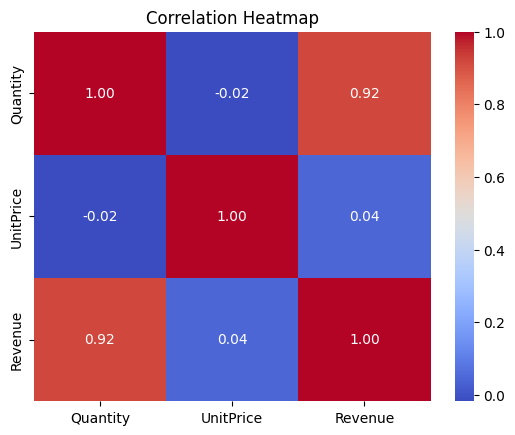

In [34]:
corr = df[["Quantity", "UnitPrice", "Revenue"]].abs().corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

We observe that Quantity and Revenue are strongly positively correlated, which is to be expected.

Let's continue by exploring our numerical values. For the sake of visual clarity, we are going to focus on the 95th percentile of the corresponding data.

Quantity distribution

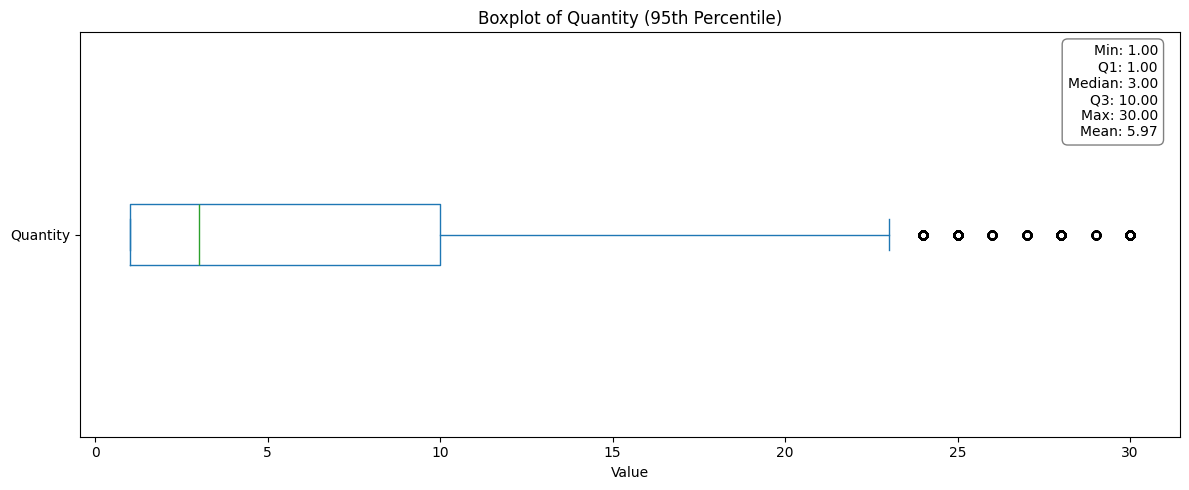

In [35]:
filter_positive = df[(df['UnitPrice'] > 0) & (df['Quantity'] > 0)]

q95 = filter_positive['Quantity'].quantile(0.95)

zoomed_df = filter_positive[filter_positive['Quantity'] <= q95]

stats = zoomed_df['Quantity'].describe()
mean_val = zoomed_df['Quantity'].mean()
min_val = stats['min']
q1 = stats['25%']
median = stats['50%']
q3 = stats['75%']
max_val = stats['max']

zoomed_df[['Quantity']].plot.box(vert=False, figsize=(12,5))

plt.title("Boxplot of Quantity (95th Percentile)")
plt.xlabel("Value")

stats_text = (
    f"Min: {min_val:.2f}\n"
    f"Q1: {q1:.2f}\n"
    f"Median: {median:.2f}\n"
    f"Q3: {q3:.2f}\n"
    f"Max: {max_val:.2f}\n"
    f"Mean: {mean_val:.2f}"
)

plt.gca().text(
    0.98, 0.97, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray')
)

plt.tight_layout()
plt.show()

Most transactions include items bought in quantities of 1-10, with a median of 3.

Unitprice distribution

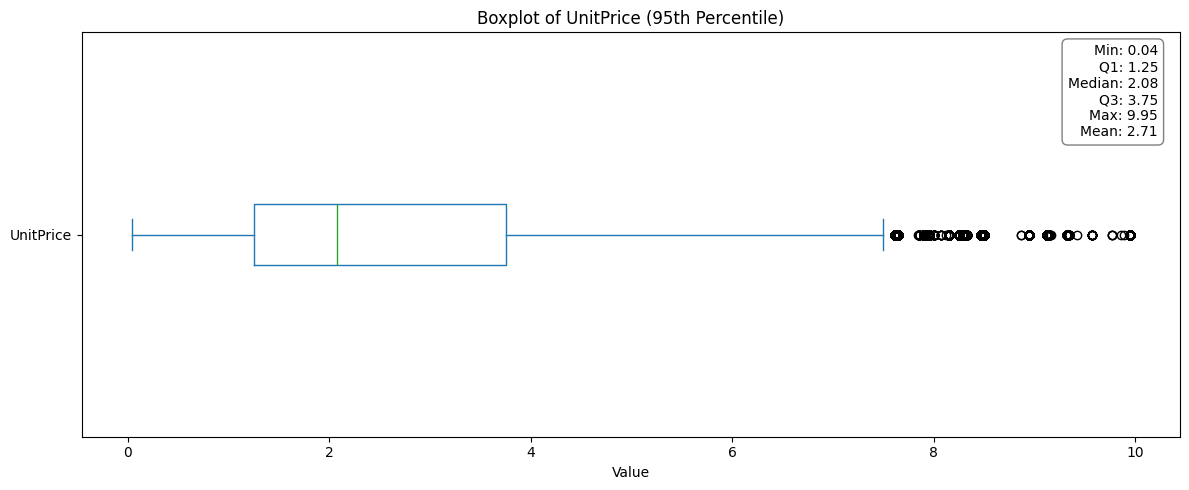

In [36]:
q95 = filter_positive['UnitPrice'].quantile(0.95)

zoomed_df = filter_positive[filter_positive['UnitPrice'] <= q95]

stats = zoomed_df['UnitPrice'].describe()
mean_val = zoomed_df['UnitPrice'].mean()
min_val = stats['min']
q1 = stats['25%']
median = stats['50%']
q3 = stats['75%']
max_val = stats['max']

zoomed_df[['UnitPrice']].plot.box(vert=False, figsize=(12,5))

plt.title("Boxplot of UnitPrice (95th Percentile)")
plt.xlabel("Value")

stats_text = (
    f"Min: {min_val:.2f}\n"
    f"Q1: {q1:.2f}\n"
    f"Median: {median:.2f}\n"
    f"Q3: {q3:.2f}\n"
    f"Max: {max_val:.2f}\n"
    f"Mean: {mean_val:.2f}"
)

plt.gca().text(
    0.98, 0.97, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray')
)

plt.tight_layout()
plt.show()

The price per item is mostly in the 1-4 range, with a median of around 2.

Revenue per transaction Distribution

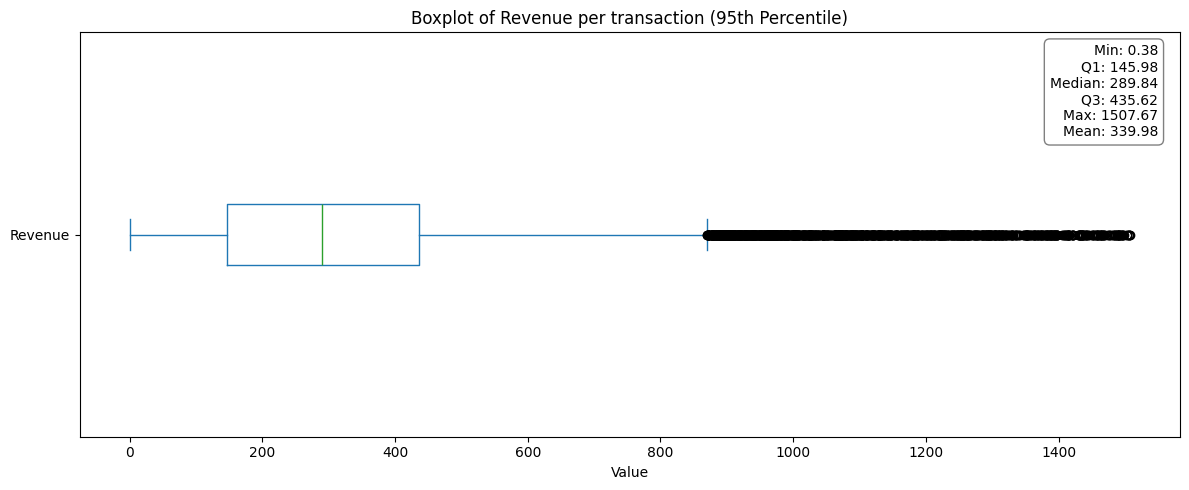

In [37]:
invoice_revenue = filter_positive.groupby("InvoiceNo")["Revenue"].sum()

q95 = invoice_revenue.quantile(0.95)

zoomed_df = invoice_revenue[invoice_revenue <= q95]

stats = zoomed_df .describe()
mean_val = zoomed_df .mean()
min_val = stats['min']
q1 = stats['25%']
median = stats['50%']
q3 = stats['75%']
max_val = stats['max']

zoomed_df.plot.box(vert=False, figsize=(12,5))

plt.title("Boxplot of Revenue per transaction (95th Percentile)")
plt.xlabel("Value")

stats_text = (
    f"Min: {min_val:.2f}\n"
    f"Q1: {q1:.2f}\n"
    f"Median: {median:.2f}\n"
    f"Q3: {q3:.2f}\n"
    f"Max: {max_val:.2f}\n"
    f"Mean: {mean_val:.2f}"
)

plt.gca().text(
    0.98, 0.97, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle='round,pad=0.4', facecolor='white', edgecolor='gray')
)

plt.tight_layout()
plt.show()

The median revenue generated from each transaction is at 290.

Now let's move on to some time series sales analysis

In [38]:
df = df.copy(deep=False)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

time_df = df.copy()
time_df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')
time_df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()
time_df['Hour'] = df['InvoiceDate'].dt.hour

Transactions per Month

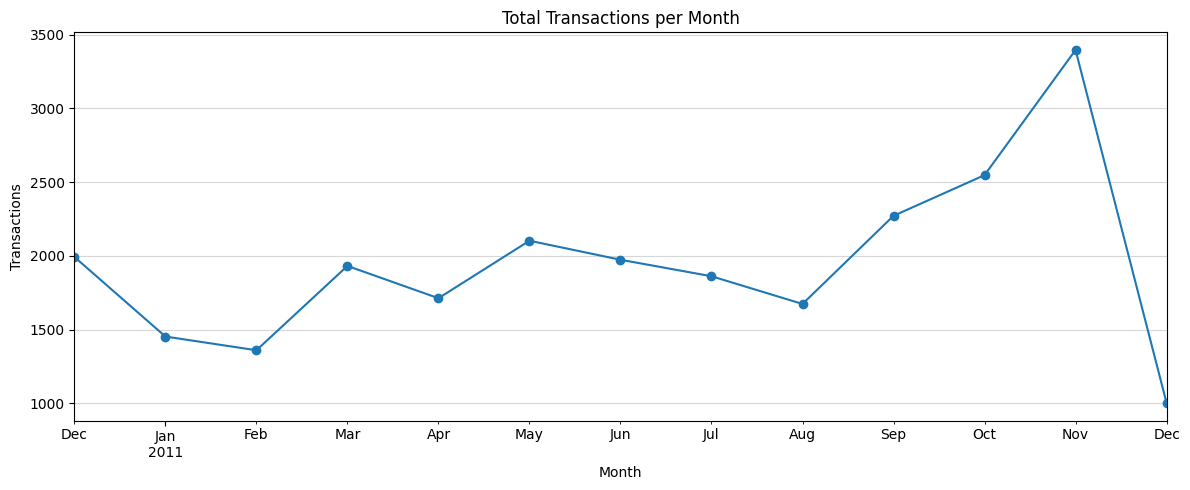

In [39]:
monthly_tx = time_df.groupby('YearMonth')['InvoiceNo'].nunique()
monthly_tx.plot(figsize=(12, 5), marker='o')
plt.title("Total Transactions per Month")
plt.ylabel("Transactions")
plt.xlabel("Month")
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

The monthly trend for transactions reveals an increasing trend towards the end of our data. The dropoff in December is explained because we are missing data for the full month.

Revenue per Month

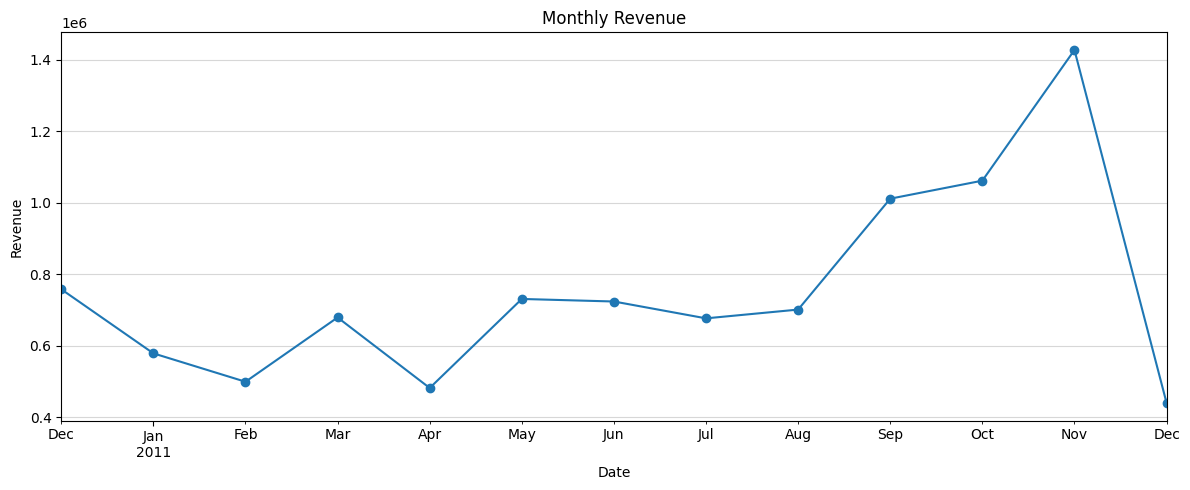

In [40]:
monthly_revenue = time_df.groupby('YearMonth')['Revenue'].sum()
monthly_revenue .plot(figsize=(12, 5), marker='o')
plt.title("Monthly Revenue")
plt.ylabel("Revenue")
plt.xlabel("Date")
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

The monthly revenue follows a very similar trend, which is to be expected.

Transactions per day of the week

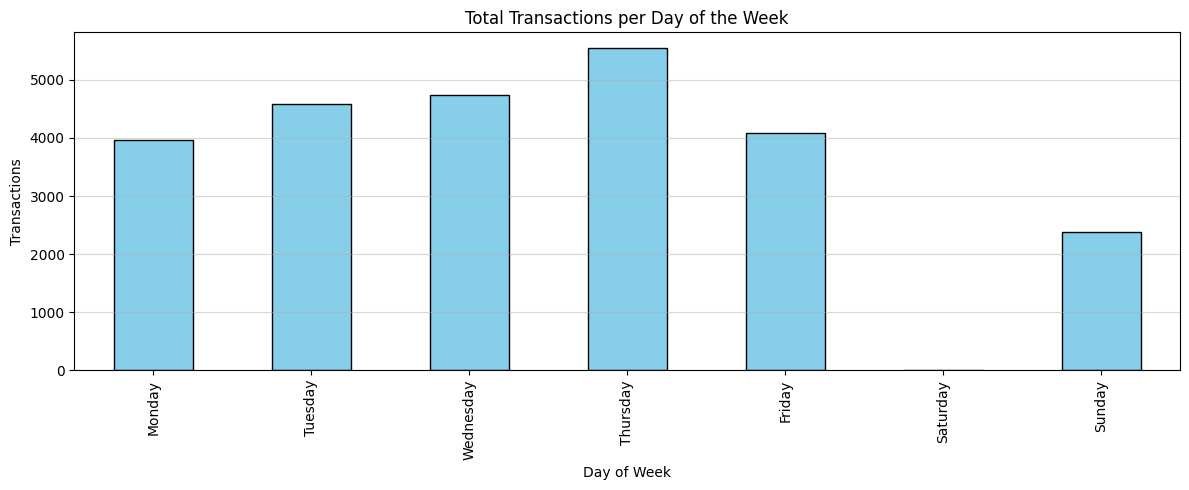

In [41]:
daily_tx = time_df.groupby('DayOfWeek')['InvoiceNo'].nunique().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

daily_tx.plot(kind='bar', figsize=(12, 5), color='skyblue', edgecolor="black")
plt.title("Total Transactions per Day of the Week")
plt.ylabel("Transactions")
plt.xlabel("Day of Week")
plt.grid(True, axis='y', alpha=0.5)
plt.tight_layout()
plt.show()

The transactions per day of the week graph shows that Thursday is the most busy day while Sunday is the least busy one. We can assume that the shop stays closed on Saturdays.

Revenue per day of the week

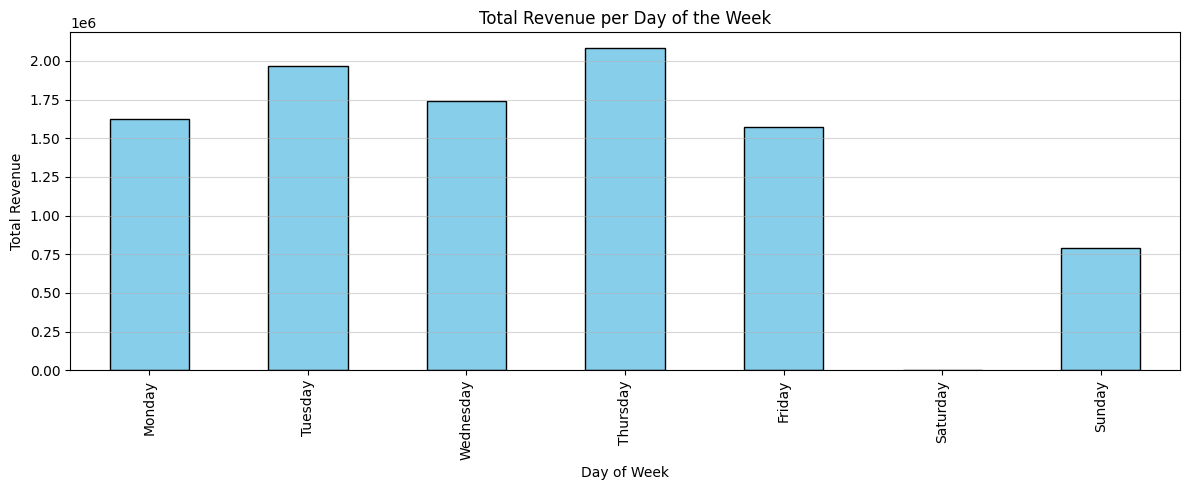

In [42]:
daily_revenue = time_df.groupby('DayOfWeek')['Revenue'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

daily_revenue.plot(kind='bar', figsize=(12, 5), color='skyblue', edgecolor="black")
plt.title("Total Revenue per Day of the Week")
plt.grid(True, axis='y', alpha=0.5)
plt.ylabel("Total Revenue")
plt.xlabel("Day of Week")

plt.tight_layout()
plt.show()

The revenue per day of the week graph closely follows the the transactions trend as expected.

Transactions per hour of the day

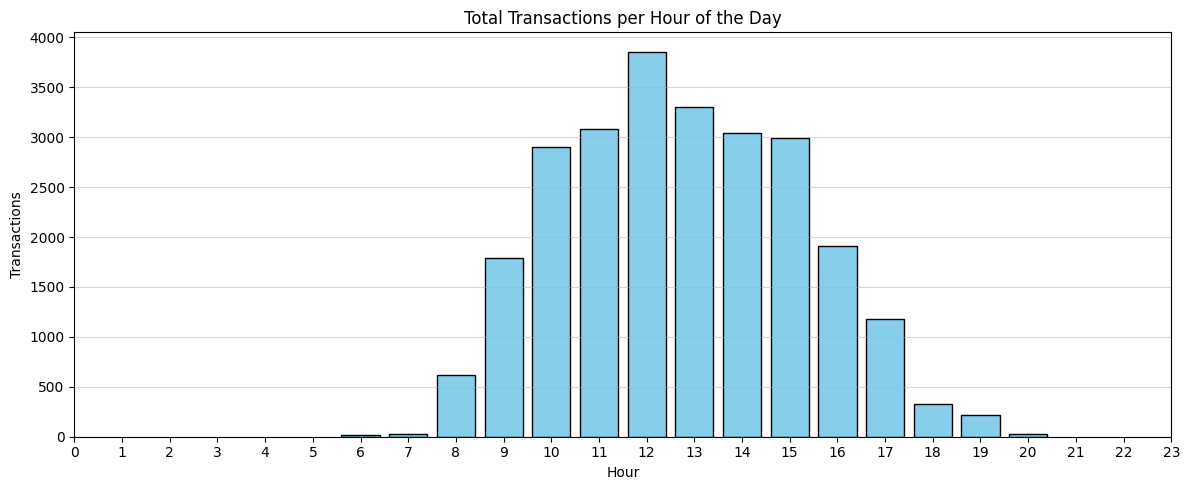

In [43]:
hourly_tx = time_df.groupby('Hour')['InvoiceNo'].nunique().reset_index()

plt.figure(figsize=(12,5))
plt.bar(hourly_tx['Hour'], hourly_tx['InvoiceNo'], color='skyblue', edgecolor='black')
plt.title("Total Transactions per Hour of the Day")
plt.ylabel("Transactions")
plt.xlabel("Hour")
plt.grid(True, axis='y', alpha=0.5)
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

The transactions per hour of day graph shows that the most busy hours are those during the middle of the day, dropping off later into the day.

Revenue per hour of day

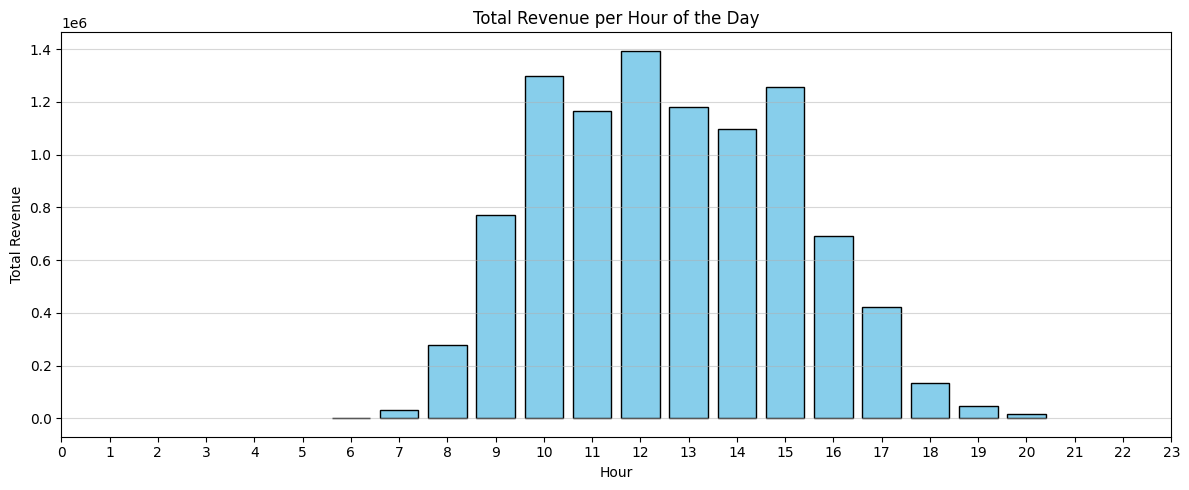

In [44]:
hourly_revenue = time_df.groupby('Hour')['Revenue'].sum().reset_index()

plt.figure(figsize=(12,5))
plt.bar(hourly_revenue['Hour'], hourly_revenue['Revenue'], color='skyblue', edgecolor='black')
plt.title("Total Revenue per Hour of the Day")
plt.ylabel("Total Revenue")
plt.xlabel("Hour")
plt.grid(True, axis='y', alpha=0.5)
plt.xticks(range(0,24))
plt.tight_layout()
plt.show()

Again, the revenue per hour of day follows a very similar trend.

###Customer RFM Analysis

Now let's perform customer RFM analysis.

In [45]:
filtered_df = df[(df['Revenue'] > 0) & (df['CustomerID'].notna())]
latest_date = filtered_df['InvoiceDate'].max()

RFM_scores = filtered_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'count',
    'Revenue': 'sum'
})

RFM_scores['InvoiceDate'] = RFM_scores['InvoiceDate'].astype(int)
RFM_scores.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

RFM_scores['R_rank'] = RFM_scores['Recency'].rank(ascending=False)
RFM_scores['F_rank'] = RFM_scores['Frequency'].rank(ascending=True)
RFM_scores['M_rank'] = RFM_scores['Monetary'].rank(ascending=True)

RFM_scores['R_rank_norm'] = (RFM_scores['R_rank'] / RFM_scores['R_rank'].max()) * 100
RFM_scores['F_rank_norm'] = (RFM_scores['F_rank'] / RFM_scores['F_rank'].max()) * 100
RFM_scores['M_rank_norm'] = (RFM_scores['M_rank'] / RFM_scores['M_rank'].max()) * 100

RFM_scores['RFM_Score'] = RFM_scores['R_rank_norm'] + RFM_scores['F_rank_norm'] + RFM_scores['M_rank_norm']
RFM_scores['RFM_Score'] *= 0.33
RFM_scores.drop(columns=['R_rank', 'F_rank', 'M_rank', 'R_rank_norm', 'F_rank_norm', 'M_rank_norm'], inplace=True)
RFM_scores = RFM_scores.round(2)

We now have the Recency, Frequency and Monetary values for each CustomerID, as well as an overall RFM score.

We can now go ahead and assign a rank to each CustomerID, based on their RFM score. We will assign the ranks based on different quantiles of our scores distribution.

In [46]:
q95 = RFM_scores['RFM_Score'].quantile(0.95)
q80 = RFM_scores['RFM_Score'].quantile(0.80)
q50 = RFM_scores['RFM_Score'].quantile(0.50)

import numpy as np
RFM_scores['RFM_Segment'] = np.where(RFM_scores['RFM_Score'] >= q95, 'Top 5%',
                                     np.where(RFM_scores['RFM_Score'] >= q80, 'Top 20%',
                                              np.where(RFM_scores['RFM_Score'] >= q50, 'Top 50%', 'Below Average')))
RFM_scores = RFM_scores.reset_index()
RFM_scores

,CustomerID,Recency,Frequency,Monetary,RFM_Score,RFM_Segment
0,12346.0,325,1,77183.60,34.47,Below Average
1,12347.0,1,182,4310.00,91.98,Top 5%
2,12348.0,74,27,1437.24,48.80,Below Average
3,12349.0,18,72,1457.55,70.39,Top 50%
4,12350.0,309,16,294.40,17.51,Below Average
...,...,...,...,...,...,...
4329,18280.0,277,10,180.60,11.91,Below Average
4330,18281.0,180,7,80.82,10.57,Below Average
4331,18282.0,7,12,178.05,39.29,Below Average
4332,18283.0,3,719,2039.58,90.05,Top 5%


Now we can calculate RFM statistics, such as the mean and median, monetary percentage, for each different rank.

In [47]:
segment_order = ["Top 5%", "Top 20%", "Top 50%", "Below Average"]

# Convert Segment column to categorical with the given order
RFM_scores["RFM_Segment"] = pd.Categorical(RFM_scores["RFM_Segment"], categories=segment_order, ordered=True)

segment_summary = (
    RFM_scores
    .groupby("RFM_Segment", observed=False)[["Recency", "Frequency", "Monetary"]]
    .agg(["mean", "median"])
    .round(2)
)
# To flatten multi-level columns into single names
segment_summary.columns = [
    f"{metric}_{stat}" for metric, stat in segment_summary.columns
]
segment_summary = segment_summary.reset_index()

Total_revenue = RFM_scores['Monetary'].sum()

Monetary_percentage = (RFM_scores.groupby('RFM_Segment', observed=False)['Monetary'].sum() / Total_revenue * 100).reset_index()['Monetary'].round(2)

segment_summary['Monetary_percentage'] = Monetary_percentage

segment_summary

,RFM_Segment,Recency_mean,Recency_median,Frequency_mean,Frequency_median,Monetary_mean,Monetary_median,Monetary_percentage
0,Top 5%,3.41,2.0,551.60,349.0,14855.93,5870.08,36.90
1,Top 20%,15.59,12.0,189.78,155.5,3960.52,2591.69,29.46
2,Top 50%,47.86,31.5,77.68,65.5,1486.86,1050.55,22.12
3,Below Average,149.68,127.0,21.74,18.0,464.34,307.78,11.52


An important observation to note here is that the top 5% of customers based on RFM scores, generate almost 37% of the total revenue, while the top 25% generate almost 2/3 of the total revenue.

###Market Basket Analysis

Finally, let's also perform market basket analysis with the FP-growth algorithm, in order to discover frequent itemsets.

In [48]:
#Create a 2d matrix with transactions and stockCodes, fill with zeros
basket = (filter_positive
          .groupby(['InvoiceNo', 'StockCode'])['Quantity']
          .sum().unstack().fillna(0))

#Convert quantity values to 1s
basket = basket.map(lambda x: 1 if x > 0 else 0)


#Generate itemsets with FP-Growth
frequent_itemsets = fpgrowth(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Sort by highest lift
rules = rules.sort_values("lift", ascending=False)

# Map StockCode → most common Description
stock_desc_map = (filter_positive.groupby('StockCode')['Description']
                  .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None))

#Convert stockCodes into Descriptions
def decode_items(itemset):
    return [stock_desc_map.get(x, x) for x in itemset]

rules['antecedents'] = rules['antecedents'].apply(lambda x: decode_items(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: decode_items(list(x)))

#Keep only useful columns
rules_display = rules[['antecedents','consequents','support','confidence','lift']]
rules_display.head(10)

,antecedents,consequents,support,confidence,lift
1913,[HERB MARKER THYME],"[HERB MARKER ROSEMARY, HERB MARKER PARSLEY]",0.010267,0.856540,78.773800
1912,"[HERB MARKER ROSEMARY, HERB MARKER PARSLEY]",[HERB MARKER THYME],0.010267,0.944186,78.773800
1914,[HERB MARKER ROSEMARY],"[HERB MARKER THYME, HERB MARKER PARSLEY]",0.010267,0.845833,78.519542
1911,"[HERB MARKER THYME, HERB MARKER PARSLEY]",[HERB MARKER ROSEMARY],0.010267,0.953052,78.519542
1916,"[HERB MARKER BASIL, HERB MARKER THYME]",[HERB MARKER ROSEMARY],0.010115,0.952381,78.464286
1921,[HERB MARKER ROSEMARY],"[HERB MARKER BASIL, HERB MARKER THYME]",0.010115,0.833333,78.464286
1917,"[HERB MARKER BASIL, HERB MARKER ROSEMARY]",[HERB MARKER THYME],0.010115,0.934579,77.972318
1920,[HERB MARKER THYME],"[HERB MARKER BASIL, HERB MARKER ROSEMARY]",0.010115,0.843882,77.972318
1902,[HERB MARKER THYME],[HERB MARKER ROSEMARY],0.011177,0.932489,76.825475
1903,[HERB MARKER ROSEMARY],[HERB MARKER THYME],0.011177,0.920833,76.825475


##SQL

> Now that we have cleaned and analyzed our data, let's put it into a database and use SQL queries for simpler analysis that does not require visualisation

In [49]:
conn = sqlite3.connect("retail_sales.db")
clean_df.to_sql("sales", conn, if_exists="replace", index=False)

533652

Top Products by Sales Quantity

In [50]:
query = '''
WITH DescriptionCounts AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS desc_count
    FROM sales
    WHERE Description IS NOT NULL AND UnitPrice > 0
    GROUP BY StockCode, Description
),
MostCommonDescription AS (
    SELECT
        dc.StockCode,
        dc.Description
    FROM DescriptionCounts dc
    JOIN (
        SELECT
            StockCode,
            MAX(desc_count) AS max_count
        FROM DescriptionCounts
        GROUP BY StockCode
    ) m
    ON dc.StockCode = m.StockCode AND dc.desc_count = m.max_count
)
SELECT
    i.StockCode,
    mcd.Description,
    SUM(i.Quantity) AS total_quantity
FROM sales i
LEFT JOIN MostCommonDescription mcd
    ON i.StockCode = mcd.StockCode
WHERE UnitPrice > 0
GROUP BY i.StockCode
ORDER BY total_quantity DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,total_quantity
0,22197,POPCORN HOLDER,56427
1,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53751
2,85099B,JUMBO BAG RED RETROSPOT,47256
3,84879,ASSORTED COLOUR BIRD ORNAMENT,36282
4,21212,PACK OF 72 RETROSPOT CAKE CASES,36016
5,85123A,WHITE HANGING HEART T-LIGHT HOLDER,35063
6,23084,RABBIT NIGHT LIGHT,30631
7,22492,MINI PAINT SET VINTAGE,26437
8,22616,PACK OF 12 LONDON TISSUES,26095
9,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24719


These are the products that were sold the most.

Top Products by Revenue

In [51]:
query = '''
WITH RevenuePerProduct AS (
    SELECT
        StockCode,
        SUM(Revenue) AS TotalRevenue
    FROM sales
    WHERE StockCode IS NOT NULL
    GROUP BY StockCode
),
Descriptions AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS freq
    FROM sales
    WHERE Description IS NOT NULL
    GROUP BY StockCode, Description
),
TopDescriptions AS (
    SELECT StockCode, Description
    FROM (
        SELECT
            StockCode,
            Description,
            RANK() OVER (PARTITION BY StockCode ORDER BY freq DESC) AS rnk
        FROM Descriptions
    )
    WHERE rnk = 1
)
SELECT
    r.StockCode,
    d.Description,
    r.TotalRevenue
FROM RevenuePerProduct r
LEFT JOIN TopDescriptions d ON r.StockCode = d.StockCode
ORDER BY r.TotalRevenue DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,TotalRevenue
0,22423,REGENCY CAKESTAND 3 TIER,164459.49
1,47566,PARTY BUNTING,98243.88
2,85123A,WHITE HANGING HEART T-LIGHT HOLDER,97838.45
3,85099B,JUMBO BAG RED RETROSPOT,92175.79
4,23084,RABBIT NIGHT LIGHT,66661.63
5,22086,PAPER CHAIN KIT 50'S CHRISTMAS,63715.24
6,84879,ASSORTED COLOUR BIRD ORNAMENT,58792.42
7,79321,CHILLI LIGHTS,53746.66
8,22502,PICNIC BASKET WICKER SMALL,51023.52
9,22197,POPCORN HOLDER,50967.92


These are the items that generated the highest revenue.

Top Products by Unique Transactions

In [52]:
query = '''
WITH DescriptionCounts AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS desc_count
    FROM sales
    WHERE Description IS NOT NULL AND Quantity > 0
    GROUP BY StockCode, Description
),
MostCommonDescription AS (
    SELECT
        dc.StockCode,
        dc.Description
    FROM DescriptionCounts dc
    JOIN (
        SELECT
            StockCode,
            MAX(desc_count) AS max_count
        FROM DescriptionCounts
        GROUP BY StockCode
    ) m
    ON dc.StockCode = m.StockCode AND dc.desc_count = m.max_count
)
SELECT
    i.StockCode,
    mcd.Description,
    COUNT(DISTINCT i.InvoiceNo) AS unique_invoices
FROM sales i
LEFT JOIN MostCommonDescription mcd
    ON i.StockCode = mcd.StockCode
WHERE i.UnitPrice > 0
GROUP BY i.StockCode, mcd.Description
ORDER BY unique_invoices DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,unique_invoices
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2240
1,22423,REGENCY CAKESTAND 3 TIER,2168
2,85099B,JUMBO BAG RED RETROSPOT,2132
3,47566,PARTY BUNTING,1705
4,20725,LUNCH BAG RED RETROSPOT,1608
5,84879,ASSORTED COLOUR BIRD ORNAMENT,1467
6,22720,SET OF 3 CAKE TINS PANTRY DESIGN,1458
7,22197,POPCORN HOLDER,1442
8,21212,PACK OF 72 RETROSPOT CAKE CASES,1334
9,22383,LUNCH BAG SUKI DESIGN,1305


These are the items that were included in the most different transactions.

Top Returned Products by Quantity

In [53]:
query = '''
WITH ReturnedItems AS (
    SELECT
        StockCode,
        SUM(ABS(Quantity)) AS TotalReturnedQty
    FROM sales
    WHERE Quantity < 0 AND StockCode IS NOT NULL AND UnitPrice > 0
    GROUP BY StockCode
),
Descriptions AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS freq
    FROM sales
    WHERE Description IS NOT NULL
    GROUP BY StockCode, Description
),
TopDescriptions AS (
    SELECT StockCode, Description
    FROM (
        SELECT
            StockCode,
            Description,
            RANK() OVER (PARTITION BY StockCode ORDER BY freq DESC) AS rnk
        FROM Descriptions
    )
    WHERE rnk = 1
)
SELECT
    r.StockCode,
    d.Description,
    r.TotalReturnedQty
FROM ReturnedItems r
LEFT JOIN TopDescriptions d ON r.StockCode = d.StockCode
ORDER BY r.TotalReturnedQty DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,TotalReturnedQty
0,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,74494
2,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9376
3,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3150
4,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2578
5,21175,GIN + TONIC DIET METAL SIGN,2030
6,22920,HERB MARKER BASIL,1527
7,22273,FELTCRAFT DOLL MOLLY,1447
8,47566B,TEA TIME PARTY BUNTING,1424
9,15034,PAPER POCKET TRAVELING FAN,1385


These were the most returned products.

Top Returned Products by Revenue

In [54]:
query = '''
WITH ReturnRevenue AS (
    SELECT
        StockCode,
        SUM(Quantity * UnitPrice) AS ReturnLoss
    FROM sales
    WHERE Quantity < 0 AND StockCode IS NOT NULL
    GROUP BY StockCode
),
Descriptions AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS freq
    FROM sales
    WHERE Description IS NOT NULL
    GROUP BY StockCode, Description
),
TopDescriptions AS (
    SELECT StockCode, Description
    FROM (
        SELECT
            StockCode,
            Description,
            RANK() OVER (PARTITION BY StockCode ORDER BY freq DESC) AS rnk
        FROM Descriptions
    )
    WHERE rnk = 1
)
SELECT
    r.StockCode,
    d.Description,
    ABS(r.ReturnLoss) AS ReturnLossAmount
FROM ReturnRevenue r
LEFT JOIN TopDescriptions d ON r.StockCode = d.StockCode
ORDER BY ReturnLossAmount DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,ReturnLossAmount
0,23843,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,23166,MEDIUM CERAMIC TOP STORAGE JAR,77479.64
2,22423,REGENCY CAKESTAND 3 TIER,9697.05
3,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6624.30
4,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,6591.42
5,23113,PANTRY CHOPPING BOARD,4803.06
6,48185,DOORMAT FAIRY CAKE,4554.90
7,21175,GIN + TONIC DIET METAL SIGN,3775.33
8,47566B,TEA TIME PARTY BUNTING,3692.95
9,22273,FELTCRAFT DOLL MOLLY,3512.65


These products accumulated the largest losses due to returns.

Top Returned Products by unique Transactions

In [55]:
query = '''
WITH DescriptionCounts AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS desc_count
    FROM sales
    WHERE Description IS NOT NULL
    GROUP BY StockCode, Description
),
MostCommonDescription AS (
    SELECT
        dc.StockCode,
        dc.Description
    FROM DescriptionCounts dc
    JOIN (
        SELECT
            StockCode,
            MAX(desc_count) AS max_count
        FROM DescriptionCounts
        GROUP BY StockCode
    ) m
    ON dc.StockCode = m.StockCode AND dc.desc_count = m.max_count
),
ReturnedInvoices AS (
    SELECT DISTINCT
        InvoiceNo,
        StockCode
    FROM sales
    WHERE Quantity < 0  -- returned items
)
SELECT
    r.StockCode,
    mcd.Description,
    COUNT(DISTINCT r.InvoiceNo) AS return_invoices_count
FROM ReturnedInvoices r
LEFT JOIN MostCommonDescription mcd
    ON r.StockCode = mcd.StockCode
GROUP BY r.StockCode, mcd.Description
ORDER BY return_invoices_count DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,return_invoices_count
0,22423,REGENCY CAKESTAND 3 TIER,183
1,22960,JAM MAKING SET WITH JARS,87
2,22720,SET OF 3 CAKE TINS PANTRY DESIGN,75
3,21232,STRAWBERRY CERAMIC TRINKET BOX,57
4,22699,ROSES REGENCY TEACUP AND SAUCER,54
5,22197,POPCORN HOLDER,50
6,22666,RECIPE BOX PANTRY YELLOW DESIGN,47
7,20725,LUNCH BAG RED RETROSPOT,43
8,21843,RED RETROSPOT CAKE STAND,43
9,85099B,JUMBO BAG RED RETROSPOT,43


These were the most commonly returned products in different transactions.

Top faulty/damaged/thrown away items by quantity

In [56]:
query = '''
WITH DescriptionCounts AS (
    SELECT
        StockCode,
        Description,
        COUNT(*) AS desc_count
    FROM sales
    WHERE Description IS NOT NULL
    GROUP BY StockCode, Description
),
MostCommonDescription AS (
    SELECT
        dc.StockCode,
        dc.Description
    FROM DescriptionCounts dc
    JOIN (
        SELECT
            StockCode,
            MAX(desc_count) AS max_count
        FROM DescriptionCounts
        GROUP BY StockCode
    ) m
    ON dc.StockCode = m.StockCode AND dc.desc_count = m.max_count
)
SELECT
    i.StockCode,
    mcd.Description,
    COUNT(*) AS count
FROM sales i
LEFT JOIN MostCommonDescription mcd
    ON i.StockCode = mcd.StockCode
WHERE i.Quantity < 0
  AND i.IsCancelled = 0       -- not cancelled
  AND (i.UnitPrice = 0 OR i.CustomerID IS NULL) -- suspicious condition
GROUP BY i.StockCode, mcd.Description
ORDER BY count DESC
LIMIT 10;
'''
pd.read_sql_query(query, conn)

,StockCode,Description,count
0,21830,ASSORTED CREEPY CRAWLIES,5
1,85175,CACTI T-LIGHT CANDLES,5
2,22719,GUMBALL MONOCHROME COAT RACK,4
3,72802C,VANILLA SCENT CANDLE JEWELLED BOX,4
4,82494L,WOODEN FRAME ANTIQUE WHITE,4
5,85172,HYACINTH BULB T-LIGHT CANDLES,4
6,20713,JUMBO BAG OWLS,3
7,20774,GREEN FERN NOTEBOOK,3
8,20892,SET/3 TALL GLASS CANDLE HOLDER PINK,3
9,20966,SANDWICH BATH SPONGE,3


These products were the most common faulty or damaged.

Cancellation Rate

In [57]:
query = '''
SELECT
  ROUND(100.0 * SUM(CASE WHEN IsCancelled THEN 1 ELSE 0 END) / COUNT(*), 2) AS cancellation_rate_pct
FROM sales;
'''
pd.read_sql_query(query, conn)

,cancellation_rate_pct
0,1.62


The total cancellation rate was 1.62%

Return Rate by Country

In [58]:
query = '''
SELECT Country,
       COUNT(*) AS total_orders,
       SUM(CASE WHEN IsCancelled THEN 1 ELSE 0 END) AS cancelled_orders,
       ROUND(100.0 * SUM(CASE WHEN IsCancelled THEN 1 ELSE 0 END) / COUNT(*), 2) AS return_rate_pct
FROM sales
GROUP BY Country
ORDER BY return_rate_pct DESC
'''
pd.read_sql_query(query, conn)

,Country,total_orders,cancelled_orders,return_rate_pct
0,USA,291,112,38.49
1,Czech Republic,28,4,14.29
2,Malta,123,14,11.38
3,Saudi Arabia,10,1,10.00
4,Japan,355,34,9.58
5,Australia,1256,73,5.81
6,Italy,783,42,5.36
7,Bahrain,19,1,5.26
8,Germany,9081,437,4.81
9,EIRE,8063,291,3.61


This is the full list of returns per country.

Top Countries by Revenue

In [59]:
query = '''
SELECT Country, ROUND(SUM(Quantity * UnitPrice), 2) AS Revenue
FROM sales
GROUP BY Country
ORDER BY Revenue DESC
'''
pd.read_sql_query(query, conn)

,Country,Revenue
0,United Kingdom,8280991.91
1,Netherlands,283479.54
2,EIRE,259380.02
3,Germany,200619.66
4,France,182076.60
5,Australia,136922.50
6,Switzerland,52483.05
7,Spain,51746.65
8,Belgium,36662.96
9,Japan,35419.79


This is the full list of revenue per country.